# PIV Tracking
- These image sets selected after the presentation
- image selected: image 1, 2, 3, 4

In [1]:
import os
import shapefile as shp
from pyproj import Proj
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import rasterio
import earthpy.spatial as es

In [2]:
# import PVI txt
set1_fn = "../5_data_processing_v2_after_presentation/2_Set1/4_PIV_64/PIV_1_image_pair.txt"
set2_fn ="../5_data_processing_v2_after_presentation/3_Set2/4_PIV_64/PIV_1_image_pair.txt"
set3_fn = "../5_data_processing_v2_after_presentation/4_Set3/3_PIV_64/PIV_1_image_pair.txt"


# Png
set1_png_fn = '../5_data_processing_v2_after_presentation/2_Set1/1_image_pair/extract2.png'
set2_png_fn ="../5_data_processing_v2_after_presentation/3_Set2/1_image_pair/extract3.png"
set3_png_fn = "../5_data_processing_v2_after_presentation/4_Set3/1_image_pair/extract4.png"

In [3]:
# read data
def read_imJ (txt_fn):
    imJ_results = pd.read_csv(txt_fn, delimiter=' ', header=None)
    
    # drop last column because of NaNs
    imJ_results = imJ_results.iloc[:, :-1] #[rows, columns]
    imJ_results.head()
    
    imJ_header = ['x', 'y', 'ux1','uy1','mag1','ang1','p1','ux2','uy2',
              'mag2','ang2','p2','ux0','uy0','mag0', 'flag']
    
    # update df columns name
    imJ_results.columns = imJ_header
    imJ_results.head()
    
    # select mag ==0 & uy1 (y direction) < 0  (-ve)
    imJ_results_copy = imJ_results.copy()
    indices_mag = imJ_results_copy[imJ_results_copy['mag1'] ==0].index
    indices_y = imJ_results_copy[imJ_results_copy['uy1'] < 0].index
    
    #drop them
    imJ_results_copy.drop(indices_mag,inplace=True)
    imJ_results_copy.drop(indices_y,inplace=True)
    
    indices_mag_small = imJ_results_copy[imJ_results_copy['mag1'] <3].index
    imJ_results_copy.drop(indices_mag_small,inplace=True)
    
    
    return imJ_results_copy


In [4]:
def interpolation (png_fn, imJ_results):
    png = plt.imread(png_fn)
    
    xi = np.linspace(0, png.shape[1], png.shape[1]) # start, stop, num of samples
    yi = np.linspace(0, png.shape[0], png.shape[0] )
    
    # take the coordinate to create grid
    triang = tri.Triangulation(imJ_results['x'].values,
                               imJ_results['y'].values)
    
    # meshgrid
    Xi, Yi = np.meshgrid(xi, yi)
    interp_disp = tri.CubicTriInterpolator(triang, imJ_results['mag1'] )
    zi_disp = interp_disp(Xi, Yi)
    
    return xi, yi, zi_disp

In [5]:

def vector_plt(imJ_results, png_fn):
    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1,1,1)
    png = plt.imread(png_fn)
    ax.imshow(png)
    
    thin = 1
    scale = 0.2 # scale = 0.05 --> U = 50
    q = ax.quiver(imJ_results['x'].values[1::thin], 
                  imJ_results['y'].values[1::thin],
                  imJ_results['ux1'].values[1::thin], 
                  imJ_results['uy1'].values[1::thin]*-1,
                  color = 'r',
                  scale = scale, 
                  scale_units = 'xy')

    # plot scale for quivers
    plt.quiverkey(q, X = 0.9, Y = 0.9, U = 20, label = '20 m',
                 labelpos = "N", labelsep = 0.06, labelcolor = 'k',
                 fontproperties = {'size':12, 'weight':'bold'},
                 angle = 0)
    
    ax = plt.gca()
    ax.ticklabel_format(style = 'plain')
    #cb = fig.colorbar(cont, orientation = 'vertical', fraction = 0.03)
    #cb.set_label('Displacement [m]')
    plt.yticks(rotation = 90, verticalalignment = 'center')
    
    plt.axis("off")
    
    plt.show()
    
    return fig
    
    

In [6]:
def displacement_plt(imJ_results, png_fn, xi, yi, zi_disp):
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1,1,1)
    png = plt.imread(png_fn)
    ax.imshow(png)

    cont = ax.contourf(xi, yi, zi_disp, levels = 30, 
                       cmap = 'jet',
                       vmin = np.percentile(imJ_results['mag1'].values, 2),
                       vmax = np.percentile(imJ_results['mag1'].values, 98),
                       alpha = 0.3)

#     thin = 1
#     scale = 0.2 # scale = 0.05 --> U = 50
#     q = ax.quiver(imJ_results['x'].values[1::thin], 
#                   imJ_results['y'].values[1::thin],
#                   imJ_results['ux1'].values[1::thin], 
#                   imJ_results['uy1'].values[1::thin]*-1,
#                   color = 'r',
#                   scale = scale, 
#                   scale_units = 'xy', alpha = 0)

#     # plot scale for quivers
#     plt.quiverkey(q, X = 0.95, Y = 1.05, U = 20, label = '2 m',
#                  labelpos = "N", labelsep = 0.06, labelcolor = 'k',
#                  fontproperties = {'size':12, 'weight':'bold'},
#                  angle = 0)


    ax = plt.gca()
    ax.ticklabel_format(style = 'plain')
    cb = fig.colorbar(cont, orientation = 'vertical', fraction = 0.03)
    cb.set_label('Displacement [m]')
    plt.yticks(rotation = 90, verticalalignment = 'center')
    
    plt.axis("off")
    plt.show()
    
    return fig


In [7]:
def disp_hist_plt(imJ_results):
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1,1,1)
    ax.hist(imJ_results["mag1"], bins = 50, color= "#ee6363")
    ax.set_xlabel("Displacement (unit: meters)", fontsize = 12)
    ax.set_ylabel("Accumulation", fontsize = 12)
    plt.grid()
    
    plt.show()

## Set 1

In [8]:
set1_result = read_imJ(set1_fn)
set1_xi, set1_yi, set1_zi_disp = interpolation(set1_png_fn, set1_result)

In [9]:
set1_result.head()

,x,y,ux1,uy1,mag1,ang1,p1,ux2,uy2,mag2,ang2,p2,ux0,uy0,mag0,flag
4477,872,472,-7.225525,0.259860,7.230196,80.529876,4768564.00,9.000000,-16.00000,18.357560,158.052661,4462077.0,-0.104201,0.801166,0.807914,0
4478,888,472,5.104886,1.234233,5.251970,84.137020,4414287.50,0.000000,-15.00000,15.000000,172.271135,3990684.0,-0.140002,1.031559,1.041016,0
4480,920,472,-0.537226,3.301586,3.345009,17.887390,2935688.75,5.000000,-16.00000,16.763055,154.000620,2770710.0,0.122418,0.805142,0.814396,0
4481,936,472,-0.151525,4.073442,4.076259,60.770736,2573485.25,12.824816,-12.44168,17.868165,75.490826,2507549.0,0.658041,0.401033,0.770614,0
4635,872,488,-0.149329,7.943389,7.944793,1.362163,7046215.00,15.000000,-8.00000,17.000000,120.511632,7015071.0,-0.093363,2.191774,2.193761,0


In [10]:
set1_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663 entries, 4477 to 8323
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       663 non-null    int64  
 1   y       663 non-null    int64  
 2   ux1     663 non-null    float64
 3   uy1     663 non-null    float64
 4   mag1    663 non-null    float64
 5   ang1    663 non-null    float64
 6   p1      663 non-null    float64
 7   ux2     663 non-null    float64
 8   uy2     663 non-null    float64
 9   mag2    663 non-null    float64
 10  ang2    663 non-null    float64
 11  p2      663 non-null    float64
 12  ux0     663 non-null    float64
 13  uy0     663 non-null    float64
 14  mag0    663 non-null    float64
 15  flag    663 non-null    int64  
dtypes: float64(13), int64(3)
memory usage: 88.1 KB


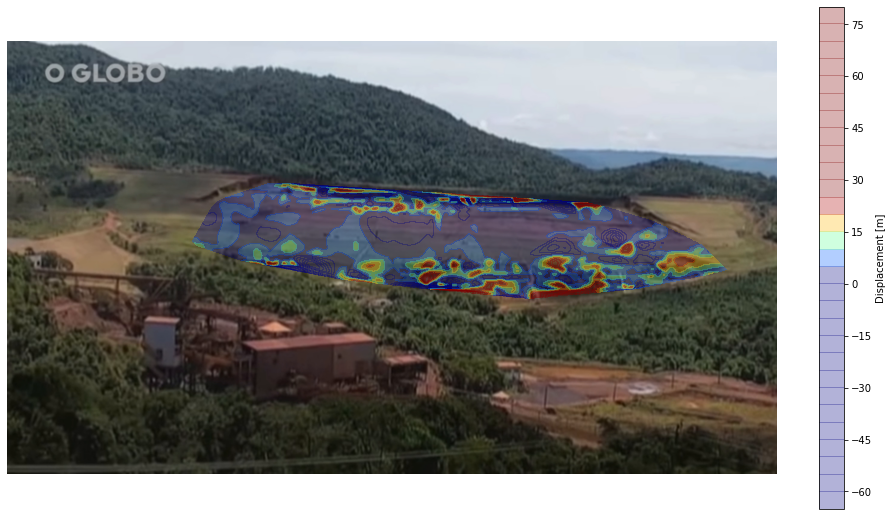

In [22]:
set1_disp_plt = displacement_plt(set1_result, set1_png_fn,set1_xi, set1_yi, set1_zi_disp )
set1_disp_plt.savefig("../4_python/output_2_newdataset/1_set1_PIV_disp.png")

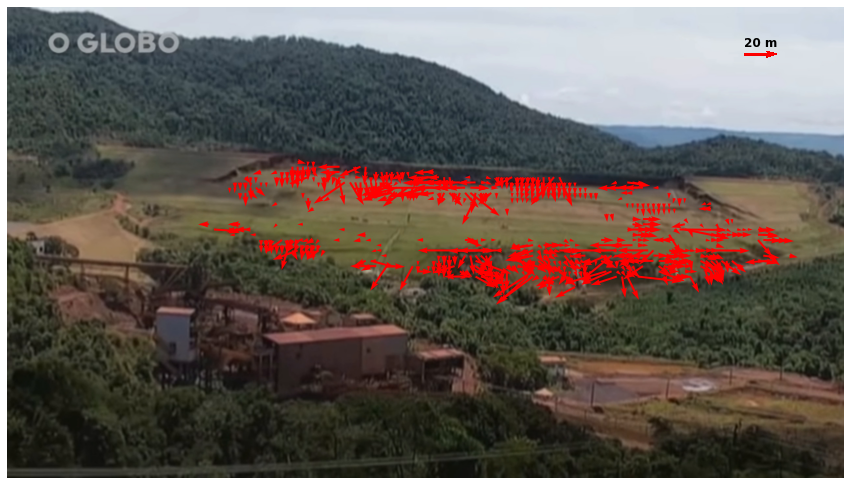

In [12]:
set1_vec_plt = vector_plt(set1_result, set1_png_fn)
set1_vec_plt.savefig("../4_python/output_2_newdataset/1_set1_PIV_vector2.png")

## Set 2


In [13]:
set2_result = read_imJ(set2_fn)
set2_xi, set2_yi, set2_zi_disp = interpolation(set2_png_fn, set2_result)

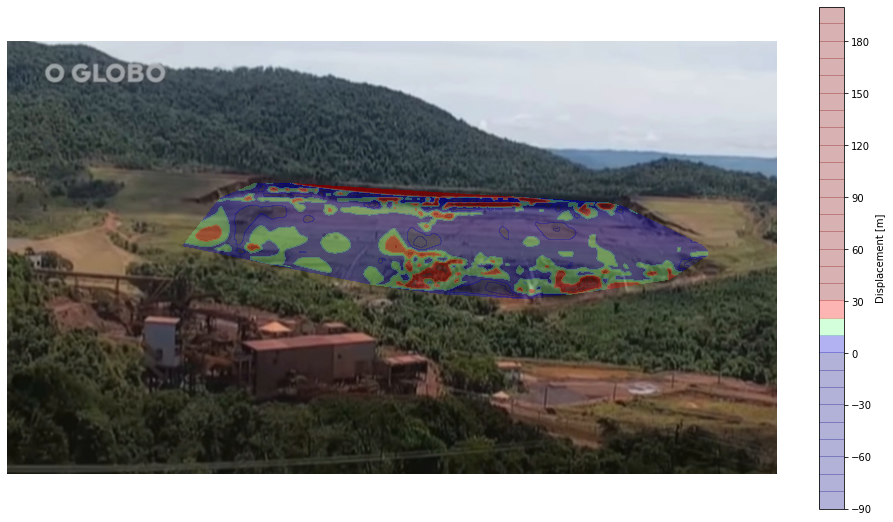

In [25]:
set2_disp_plt = displacement_plt(set2_result, set2_png_fn,set2_xi, set2_yi, set2_zi_disp )
set2_disp_plt.savefig("../4_python/output_2_newdataset/2_set2_PIV_disp.png")

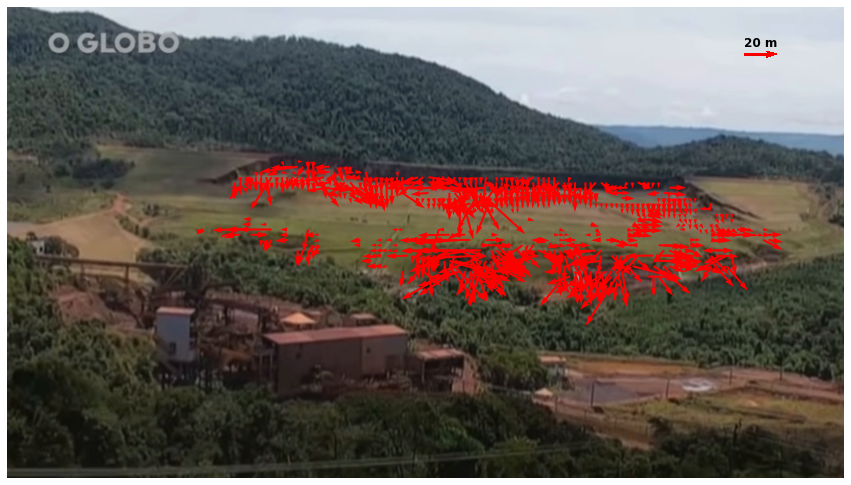

In [14]:
set2_vec_plt = vector_plt(set2_result, set2_png_fn)
set2_vec_plt.savefig("../4_python/output_2_newdataset/2_set2_PIV_vecto2r.png")

## Set 3

In [15]:
set3_result = read_imJ(set3_fn)
set3_xi, set3_yi, set3_zi_disp = interpolation(set3_png_fn, set3_result)

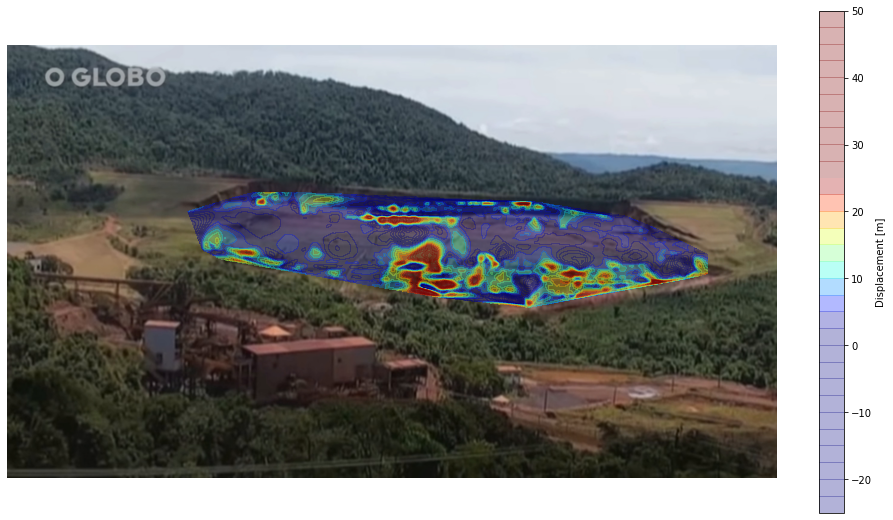

In [18]:
set3_disp_plt = displacement_plt(set3_result, set3_png_fn,set3_xi, set3_yi, set3_zi_disp )
set3_disp_plt.savefig("../4_python/output_2_newdataset/3_set3_PIV_disp.png")

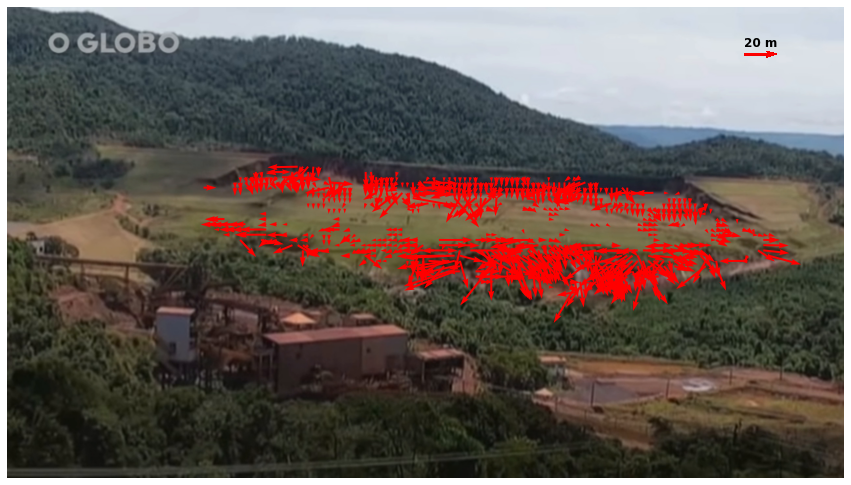

In [16]:
set3_vec_plt = vector_plt(set3_result, set3_png_fn)
set3_vec_plt.savefig("../4_python/output_2_newdataset/3_set3_PIV_vector2.png")